In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cal import cal_woe_iv, feature_selection, vif_cal, replace_woe
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

这里的cal这个文件里的函数是参考以下的文章，然后自己写的，不好看就先不贴了。  
https://cloud.tencent.com/developer/article/1092198  
https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html  
https://www.jianshu.com/p/b1b1344bd99f

# 1.特征选取

In [2]:
df = pd.read_csv('../data/rough_clean_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238636 entries, 0 to 238635
Data columns (total 55 columns):
emp_length                    238636 non-null object
home_ownership                238636 non-null object
annual_inc                    238636 non-null float64
verification_status           238636 non-null object
purpose                       238636 non-null object
dti                           238636 non-null float64
inq_last_6mths                238636 non-null float64
open_acc                      238636 non-null float64
revol_bal                     238636 non-null float64
revol_util                    238636 non-null float64
total_acc                     238636 non-null float64
tot_cur_bal                   238636 non-null float64
open_acc_6m                   238636 non-null float64
open_act_il                   238636 non-null float64
open_il_12m                   238636 non-null float64
open_il_24m                   238636 non-null float64
mths_since_rcnt_il           

可以看到经过前一篇数据处理之后，变量数量从145个减少到了55个不过依然很多，这里使用评分卡模型中经常使用的woe与iv来进行变量的筛选。

In [4]:
woe_iv_list = cal_woe_iv(df)
feature_list = feature_selection(woe_iv_list)

In [5]:
feature_list

,col,iv
0,verification_status,0.077051
1,purpose,0.059431
2,inq_last_6mths,0.039703
3,revol_bal,0.028345
4,max_bal_bc,0.036580
5,total_rev_hi_lim,0.048971
6,bc_open_to_buy,0.047787
7,mo_sin_rcnt_tl,0.025453
8,mths_since_recent_inq,0.056935
9,num_tl_op_past_12m,0.027613


1.可以看到这里有11个变量被挑选出来了，其中verification_status与purpose是类别变量，其他都是连续变量。在这里我们对于连续型变量用方差膨胀因子来查看多重共线性。  
2.发现所有的变量对应的iv值都不大没有超过0.1的，这个数据集(在我没有构造衍生变量的情况下)中没有预测能力特别强的字段。

In [6]:
vif_cal(df,feature_list)

,VIF Factor,features
0,1.724098,inq_last_6mths
1,12.995219,revol_bal
2,5.508267,max_bal_bc
3,28.831864,total_rev_hi_lim
4,21.341303,bc_open_to_buy
5,1.779618,mo_sin_rcnt_tl
6,2.304276,mths_since_recent_inq
7,2.409998,num_tl_op_past_12m
8,2.636940,tot_hi_cred_lim
9,27.517517,total_bc_limit


In [7]:
vif_cal(df,feature_list)['features'].values

array(['inq_last_6mths', 'revol_bal', 'max_bal_bc', 'total_rev_hi_lim',
       'bc_open_to_buy', 'mo_sin_rcnt_tl', 'mths_since_recent_inq',
       'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit'],
      dtype=object)

从结果中可以看出revol_bal,total_rev_hi_lim,bc_open_to_buy,total_bc_limit,max_bal_bc的方差膨胀因子大于5，说明存在较强的多重共线性，这里我们按照上面得到的iv值的大小来对于iv值小的字段进行删除，之后再计算方差膨胀因子，直到没有字段的方差膨胀因子大于5。这里就不进行演示了，无非重复过程而已。最后得到以下的字段来进行训练。
https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [8]:
data_x = df[['inq_last_6mths', 'mo_sin_rcnt_tl', 'mths_since_recent_inq',
       'tot_hi_cred_lim', 'total_bc_limit']].select_dtypes(include=['float64'])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]
vif["features"] = data_x.columns
vif

,VIF Factor,features
0,1.255104,inq_last_6mths
1,1.649291,mo_sin_rcnt_tl
2,2.015897,mths_since_recent_inq
3,2.177130,tot_hi_cred_lim
4,2.315525,total_bc_limit


最后得到此结果，发现已经没有方差膨胀因子大于5的字段了。

In [9]:
feature_df = df[['verification_status', 'purpose', 'inq_last_6mths', 'mo_sin_rcnt_tl', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'total_bc_limit']].copy()
feature_df['class'] = df['class'].copy()
woe_list= cal_woe_iv(feature_df)

由于本次建模中分箱使用的是无监督分箱，因此需要检查一下单调性，并且顺便探究一下字段的影响。

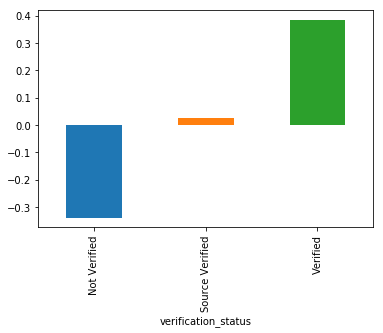

In [10]:
woe_list[0][1].plot(kind='bar')

这个结果很出乎我的意料，因为本次建模中使用的是1代表坏人(一般来说都是这样),
那么woe为正的部分则说明会增加为坏人的风险。
而个人的固有理解是收入来源被验证过的人应该不容易违约才对，不过这个数据集里看来并不是这样。(心理模型再一次失败)

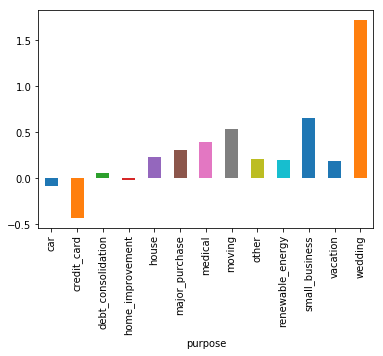

In [11]:
woe_list[1][1].plot(kind='bar')

这是借款目的所对应的，发现以结婚为目的借钱的人最有风险。

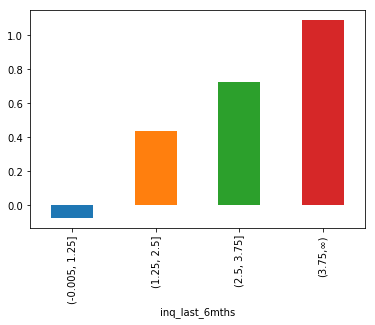

In [12]:
woe_list[2][1].rename({woe_list[2][1].index[3]:'(3.75,∞)'},inplace = True)
woe_list[2][1].plot(kind='bar')

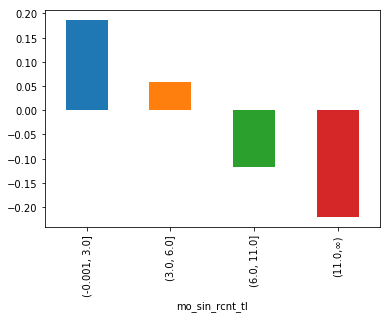

In [13]:
woe_list[3][1].rename({woe_list[3][1].index[3]:'(11.0,∞)'},inplace = True)
woe_list[3][1].plot(kind='bar')

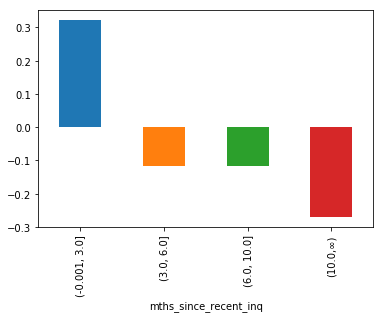

In [14]:
woe_list[4][1].rename({woe_list[4][1].index[3]:'(10.0,∞)'},inplace = True)
woe_list[4][1].plot(kind='bar')

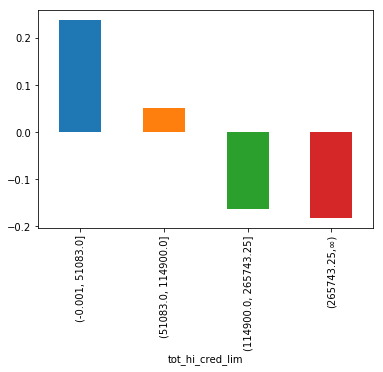

In [15]:
woe_list[5][1].rename({woe_list[5][1].index[3]:'(265743.25,∞)'},inplace = True)
woe_list[5][1].plot(kind='bar')

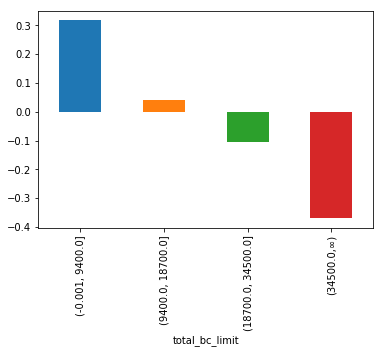

In [16]:
woe_list[6][1].rename({woe_list[6][1].index[3]:'(34500.0,∞)'},inplace = True)
woe_list[6][1].plot(kind='bar')

综合以上所有图，除了分类变量外，连续变量都已经单调化了。下面可以进行建模了。 

# 2.建模

 首先需要处理一下数据不平衡的问题,正如前篇中指出的正反例极度不平衡，这样建模的话会有问题。
首先我们来看一下这样建模会出什么问题。
将数据集进行woe编码，然后进行建模。

In [17]:
woe_df = replace_woe(feature_df) #将特征转换为woe值
X = woe_df.iloc[:,:-1].values
y = woe_df.iloc[:,-1].values
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
clf = LogisticRegression(random_state=0, solver='saga').fit(x_train, y_train)
clf.score(x_test,y_test)

0.9555397251089507

发现准确率这么高，但是仔细考虑一下之后发现，这其实和本身正例占有的数目差不多，我们来看一下预测结果。

In [18]:
y_pred = clf.predict(x_test)
sum(y_pred)

0

发现预测结果都是零,这就说明所有的结果都被预测为了正类。这个是因为什么原因呢？
（需要完成的任务）：1结合损失函数来说明为什么会这样。因为从函数来看优化的是整体的。所以单纯这样不行。
              2说出解决办法 调整阈值或者重新采样
              3重新采样后的结果

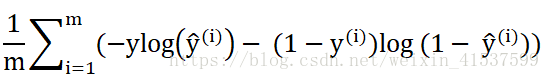

首先逻辑回归的损失函数为以上的形式，整个逻辑回归的优化目标是使得整体的损失函数的值变小。  
因此，如果数据为本次数据集这样很不平衡的形式，自然而然要使得分类器会偏向大类，这样才能使得整体的损失函数的值较小。  
因此这样导致了准确率十分高，但是作为分类器是失败的。  
那么怎样解决这个问题呢，一个可行的方法就是用过采样或者欠采样。  
本次采用欠采样来进行操作。

In [22]:
#首先按照4:1的比例将训练集分开
from sklearn.model_selection import train_test_split
train,test = train_test_split(woe_df,test_size=0.2,random_state=0)
x_test_1 = test.iloc[:,:-1]
y_test_1 = test.iloc[:,-1]

In [23]:
train['class'].value_counts()

0    182788
1      8120
Name: class, dtype: int64

发现将数据集分开以后，训练集中有8120个违约类，因此从需要从正类中重新取样8120个非违约类。

In [25]:
df1 = train.loc[train['class'] == 0]
df2 = train.loc[train['class'] == 1]
df1 = df1.sample(n=8120)
train = pd.concat([df1,df2],ignore_index = True)
train['class'].value_counts()

1    8120
0    8120
Name: class, dtype: int64

进行建模

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = train.iloc[:,:-1].values
y = train.iloc[:,-1].values
clf = LogisticRegression(random_state=0, solver='saga').fit(X, y)
clf.score(x_test_1,y_test_1)

0.606855514582635

发现模型效果很差，不过这个从一开始的IV值中也可以看出来，因为IV值均较小，没有预测能力特别强的特征。

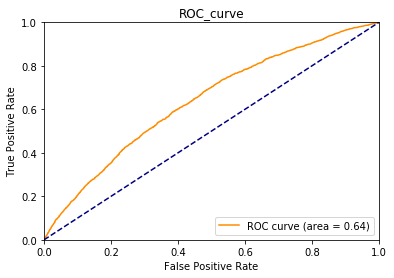

In [30]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test_1, clf.predict_proba(x_test_1)[:,-1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

看ROC曲线也可以看出模型的效果并不好。这有可能是数据集本身的问题，也很有可能是我对于金融评分卡中的业务理解太差，导致无法创造出强有力的特征有关系。

# 3.评分卡转换

评分卡转换的环节这里主要介绍如何做。
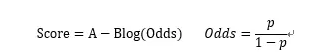

首先评分卡由上面的左边的公式来决定。A为初始分值,B为比例系数。  
log(odds)计算之后就将建模过程中的逻辑回归的系数给取出来了，这就出现的线性的部分。  
这里我们取基础分为200分，比例系数为20分，来进行计算，并将部分结果放在下面。

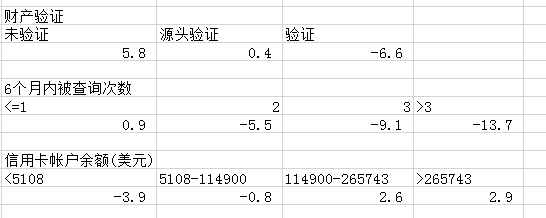

可以发现进行计算之后，已经得到了分值。具体计算的时候只要按照相应数值进行计算就好。